# Convolutional Neural Network: fashtion mnist dataset

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainLoader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size=64, shuffle=False)


#set label loại theo name
classes = ["T-shirt/top",
         "Trouser",
         "Pullover",
         "Dress",
         "Coat",
         "Sandal",
         "Shirt",
         "Sneaker",
         "Bag",
         "Ankle boot"]

Ta sẽ xem thử ảnh trong 1 mẫu

Ankle boot Sneaker Ankle boot Pullover


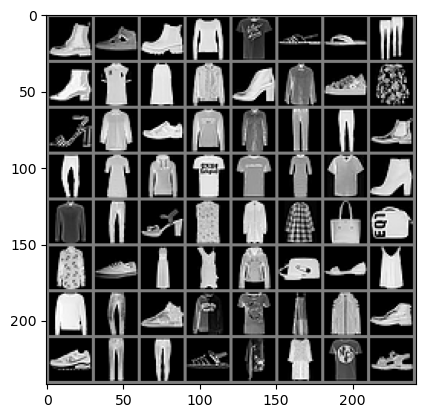

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainLoader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Sau khi ta nhìn nhận ta có thể dùng một số thử thuật để trực quan hóa và quan sát dữ liệu nhưng phần đó ta sẽ làm sao để có thể đẩy cao độ chính xác của ảnh.

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)    # 28x28 -> 24x24
        self.pool = nn.MaxPool2d(2, 2)     # 24x24 -> 12x12
        self.conv2 = nn.Conv2d(6, 16, 5)   # 24x24 -> 20x20 -> 16x16

        # Tính số chiều đầu vào cho fc1 tự động
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            dummy = self.pool(self.conv2(self.pool(self.conv1(dummy))))
            self.flatten_dim = dummy.view(1, -1).size(1) + 1

        self.fc1 = nn.Linear(self.flatten_dim, 120)
        self.fc2 = nn.Linear(121, 84)
        self.fc3 = nn.Linear(85, 10)
    def add_ones_column(self,x):
      if x.dim() != 2:
        raise ValueError("Input tensor must be 2D.")
      ones_column = torch.ones(x.size(0), 1, device=x.device)
      return torch.cat((ones_column, x), dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.add_ones_column(x)
        x = F.relu(self.fc1(x))
        x = self.add_ones_column(x)
        x = F.relu(self.fc2(x))
        x = self.add_ones_column(x)
        return self.fc3(x)
Net()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=257, out_features=120, bias=True)
  (fc2): Linear(in_features=121, out_features=84, bias=True)
  (fc3): Linear(in_features=85, out_features=10, bias=True)
)

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

@torch.no_grad()
def evaluate_model(dataloader, model):
  model.eval()
  total_correct = 0
  total_samples = 0
  all_preds = []
  all_labels = []
  for X, y in dataloader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    preds = model(X)
    predicted = torch.argmax(preds,dim=1)
    total_correct += (predicted == y).sum().item()
    total_samples += y.size(0)
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(y.cpu().numpy())
  acc = total_correct / total_samples
  f1 = f1_score(all_labels, all_preds, average='macro')
  return acc, f1

### 3. Định nghĩa loss function và otimizer

In [5]:
net = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

### 4. train the network

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

for epoch in range(10):
    loss = train_loop(trainLoader, net, criterion, optimizer)
    acc, f1 = evaluate_model(testLoader, net)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f} , accuracy: {acc:.4f}, f1: {f1:.4f}")
print("Finished")

Epoch 1, Loss: 0.5346 , accuracy: 0.8533, f1: 0.8524
Epoch 2, Loss: 0.3601 , accuracy: 0.8586, f1: 0.8585
Epoch 3, Loss: 0.3166 , accuracy: 0.8763, f1: 0.8764
Epoch 4, Loss: 0.2894 , accuracy: 0.8784, f1: 0.8795
Epoch 5, Loss: 0.2728 , accuracy: 0.8871, f1: 0.8862
Epoch 6, Loss: 0.2551 , accuracy: 0.8898, f1: 0.8891
Epoch 7, Loss: 0.2455 , accuracy: 0.8896, f1: 0.8888
Epoch 8, Loss: 0.2342 , accuracy: 0.8944, f1: 0.8949
Epoch 9, Loss: 0.2236 , accuracy: 0.8943, f1: 0.8932
Epoch 10, Loss: 0.2165 , accuracy: 0.8981, f1: 0.8981
Finished


In [8]:
PATH = './fashion_net.pth'
torch.save(net.state_dict(), PATH)

### 5. kiểm tran trên tập test.

GroundTruth:  Ankle boot Pullover Trouser Trouser Shirt


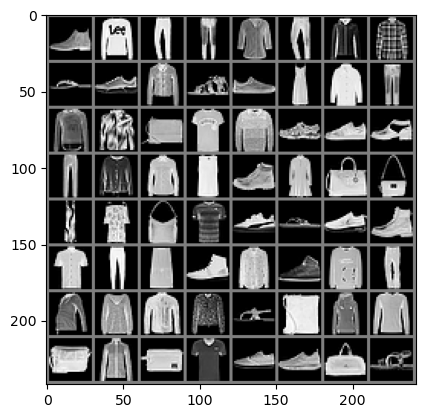

In [30]:
dataiter = iter(testLoader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [31]:
net = Net().to(DEVICE)
net.load_state_dict(torch.load('model/fashion_net.pth'))
outputs = net(images.to(DEVICE))

Lấy ra nhãn dựa vào xác xuất lớn nhất của phân phối xác xuất đầu ra

In [32]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))

Predicted:  Ankle boot Pullover Trouser Trouser T-shirt/top


Có thể thấy được kết quả khá tốt và 5 cái đầu dự đoán gần như hoàn toàn đúng. kiểm tra trên toàn bộ các quan sát. kiễm tra mức độ chính xác trên từng class một.

In [33]:
class_correct = [0. for _ in range(10)]
class_total = [0. for _ in range(10)]

with torch.no_grad():
    for data in testLoader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'Accuracy of {classes[i]:5s} : {acc:2.2f} %')


Accuracy of T-shirt/top : 84.60 %
Accuracy of Trouser : 97.30 %
Accuracy of Pullover : 84.90 %
Accuracy of Dress : 92.00 %
Accuracy of Coat  : 82.50 %
Accuracy of Sandal : 97.30 %
Accuracy of Shirt : 71.50 %
Accuracy of Sneaker : 96.60 %
Accuracy of Bag   : 96.10 %
Accuracy of Ankle boot : 95.30 %


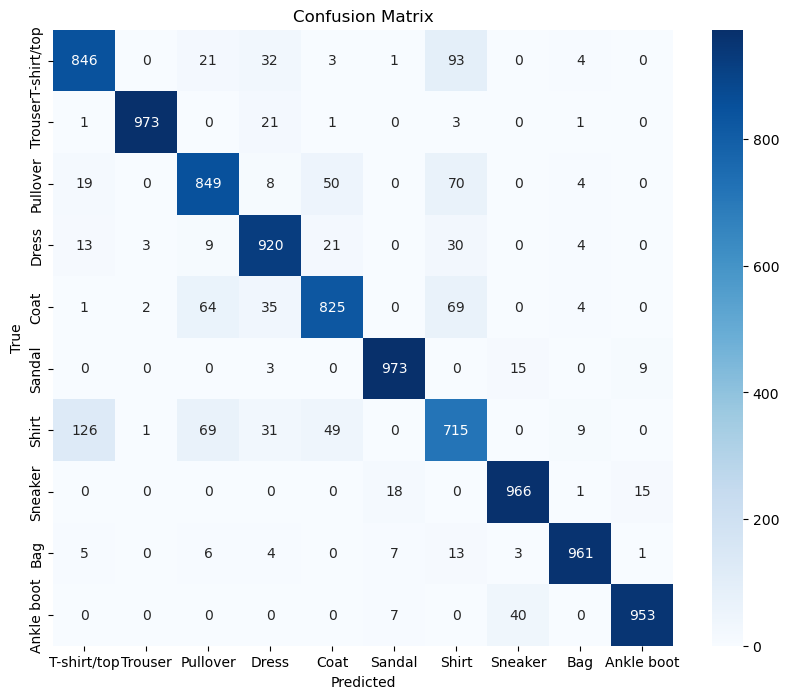

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testLoader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Có thể thấy chỉ với một cấu trúc đơn gian mà đã có thể đạt kết quả như vậy nếu có thể cải thiện thêm thì kết quả sẽ cao hơn nữa.